In [69]:
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter

from models import *

In [116]:
# Pre-trained models
trained_scene_flow_model = './trained/pretrained_sceneflow.tar'
trained_kitti_2015_model = './trained/pretrained_model_KITTI2015.tar'

maxdisp = 192
seed = 1

is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda_available else 'cpu')

torch.manual_seed(seed)
if is_cuda_available:
    torch.cuda.manual_seed(seed)

In [117]:
# Load the Scene Flow pre-trained model
scene_flow_model = stackhourglass(maxdisp)
scene_flow_model = nn.DataParallel(scene_flow_model, device_ids=[0])
scene_flow_model = scene_flow_model.to(device)

print('Loading PSMNet trained on Scene Flow')
scene_flow_state_dict = torch.load(trained_scene_flow_model, map_location=device)
scene_flow_model.load_state_dict(scene_flow_state_dict['state_dict'])
scene_flow_model.eval()

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in scene_flow_model.parameters()])))

Loading PSMNet trained on Scene Flow
Number of model parameters: 5224768


In [118]:
# Load the KITTI 2015 pre-trained model
kitti_2015_model = stackhourglass(maxdisp)
kitti_2015_model = nn.DataParallel(kitti_2015_model, device_ids=[0])
kitti_2015_model = kitti_2015_model.to(device)

print('Loading PSMNet trained on KITTI 2015')
kitti_2015_state_dict = torch.load(trained_kitti_2015_model, map_location=device)
kitti_2015_model.load_state_dict(kitti_2015_state_dict['state_dict'])
kitti_2015_model.eval()

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in kitti_2015_model.parameters()])))

Loading PSMNet trained on KITTI 2015
Number of model parameters: 5224768


In [21]:
# Summarize the models
scene_flow_model
kitti_2015_model

DataParallel(
  (module): PSMNet(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU(inplace=True)
        (2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): ReLU(inplace=True)
        (4): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (5): ReLU(inplace=True)
      )
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Sequential(
            (0): Sequential(
    

In [ ]:
############################################## NUMPY ##############################################

In [119]:
# Extract weights from Scene Flow pre-trained model

# conv0_x
scene_flow_model_conv0_conv_weights = []
scene_flow_model_conv0_batchnorm_weights = []

for i in range(3):
    scene_flow_model_conv0_conv_weights.append(scene_flow_model.module.feature_extraction.firstconv[i * 2][0].weight.cpu().data.numpy())
    scene_flow_model_conv0_batchnorm_weights.append(scene_flow_model.module.feature_extraction.firstconv[i * 2][1].weight.cpu().data.numpy())

# conv1_x
scene_flow_model_conv1_conv1_weights = []
scene_flow_model_conv1_batchnorm1_weights = []
scene_flow_model_conv1_conv2_weights = []
scene_flow_model_conv1_batchnorm2_weights = []

for i in range(3):
    scene_flow_model_conv1_conv1_weights.append(scene_flow_model.module.feature_extraction.layer1[i].conv1[0][0].weight.cpu().data.numpy())
    scene_flow_model_conv1_batchnorm1_weights.append(scene_flow_model.module.feature_extraction.layer1[i].conv1[0][1].weight.cpu().data.numpy())
    scene_flow_model_conv1_conv2_weights.append(scene_flow_model.module.feature_extraction.layer1[i].conv2[0].weight.cpu().data.numpy())
    scene_flow_model_conv1_batchnorm2_weights.append(scene_flow_model.module.feature_extraction.layer1[i].conv2[1].weight.cpu().data.numpy())

# conv2_x
scene_flow_model_conv2_conv1_weights = []
scene_flow_model_conv2_batchnorm1_weights = []
scene_flow_model_conv2_conv2_weights = []
scene_flow_model_conv2_batchnorm2_weights = []
scene_flow_model_conv2_conv3_weights = None
scene_flow_model_conv2_batchnorm3_weights = None

for i in range(16):
    scene_flow_model_conv2_conv1_weights.append(scene_flow_model.module.feature_extraction.layer2[i].conv1[0][0].weight.cpu().data.numpy())
    scene_flow_model_conv2_batchnorm1_weights.append(scene_flow_model.module.feature_extraction.layer2[i].conv1[0][1].weight.cpu().data.numpy())
    scene_flow_model_conv2_conv2_weights.append(scene_flow_model.module.feature_extraction.layer2[i].conv2[0].weight.cpu().data.numpy())
    scene_flow_model_conv2_batchnorm2_weights.append(scene_flow_model.module.feature_extraction.layer2[i].conv2[1].weight.cpu().data.numpy())
    
    if i == 0:
        scene_flow_model_conv2_conv3_weights = scene_flow_model.module.feature_extraction.layer2[i].downsample[0].weight.cpu().data.numpy()
        scene_flow_model_conv2_batchnorm3_weights = scene_flow_model.module.feature_extraction.layer2[i].downsample[1].weight.cpu().data.numpy()

# conv3_x
scene_flow_model_conv3_conv1_weights = []
scene_flow_model_conv3_batchnorm1_weights = []
scene_flow_model_conv3_conv2_weights = []
scene_flow_model_conv3_batchnorm2_weights = []
scene_flow_model_conv3_conv3_weights = None
scene_flow_model_conv3_batchnorm3_weights = None

for i in range(3):
    scene_flow_model_conv3_conv1_weights.append(scene_flow_model.module.feature_extraction.layer3[i].conv1[0][0].weight.cpu().data.numpy())
    scene_flow_model_conv3_batchnorm1_weights.append(scene_flow_model.module.feature_extraction.layer3[i].conv1[0][1].weight.cpu().data.numpy())
    scene_flow_model_conv3_conv2_weights.append(scene_flow_model.module.feature_extraction.layer3[i].conv2[0].weight.cpu().data.numpy())
    scene_flow_model_conv3_batchnorm2_weights.append(scene_flow_model.module.feature_extraction.layer3[i].conv2[1].weight.cpu().data.numpy())
    
    if i == 0:
        scene_flow_model_conv3_conv3_weights = scene_flow_model.module.feature_extraction.layer3[i].downsample[0].weight.cpu().data.numpy()
        scene_flow_model_conv3_batchnorm3_weights = scene_flow_model.module.feature_extraction.layer3[i].downsample[1].weight.cpu().data.numpy()
        
# conv4_x
scene_flow_model_conv4_conv1_weights = []
scene_flow_model_conv4_batchnorm1_weights = []
scene_flow_model_conv4_conv2_weights = []
scene_flow_model_conv4_batchnorm2_weights = []

for i in range(3):
    scene_flow_model_conv4_conv1_weights.append(scene_flow_model.module.feature_extraction.layer4[i].conv1[0][0].weight.cpu().data.numpy())
    scene_flow_model_conv4_batchnorm1_weights.append(scene_flow_model.module.feature_extraction.layer4[i].conv1[0][1].weight.cpu().data.numpy())
    scene_flow_model_conv4_conv2_weights.append(scene_flow_model.module.feature_extraction.layer4[i].conv2[0].weight.cpu().data.numpy())
    scene_flow_model_conv4_batchnorm2_weights.append(scene_flow_model.module.feature_extraction.layer4[i].conv2[1].weight.cpu().data.numpy())

# branch_1
scene_flow_model_branch1_conv_weights = scene_flow_model.module.feature_extraction.branch1[1][0].weight.cpu().data.numpy()
scene_flow_model_branch1_batchnorm_weights = scene_flow_model.module.feature_extraction.branch1[1][1].weight.cpu().data.numpy()

# branch_2
scene_flow_model_branch2_conv_weights = scene_flow_model.module.feature_extraction.branch2[1][0].weight.cpu().data.numpy()
scene_flow_model_branch2_batchnorm_weights = scene_flow_model.module.feature_extraction.branch2[1][1].weight.cpu().data.numpy()

# branch_3
scene_flow_model_branch3_conv_weights = scene_flow_model.module.feature_extraction.branch3[1][0].weight.cpu().data.numpy()
scene_flow_model_branch3_batchnorm_weights = scene_flow_model.module.feature_extraction.branch3[1][1].weight.cpu().data.numpy()

# branch_4
scene_flow_model_branch4_conv_weights = scene_flow_model.module.feature_extraction.branch4[1][0].weight.cpu().data.numpy()
scene_flow_model_branch4_batchnorm_weights = scene_flow_model.module.feature_extraction.branch4[1][1].weight.cpu().data.numpy()

# fusion
scene_flow_model_fusion_conv1_weights = scene_flow_model.module.feature_extraction.lastconv[0][0].weight.cpu().data.numpy()
scene_flow_model_fusion_batchnorm_weights = scene_flow_model.module.feature_extraction.lastconv[0][1].weight.cpu().data.numpy()
scene_flow_model_fusion_conv2_weights = scene_flow_model.module.feature_extraction.lastconv[2].weight.cpu().data.numpy()

In [120]:
# Extract weights from KITTI 2015 pre-trained model

# conv0_x
kitti_2015_model_conv0_conv_weights = []
kitti_2015_model_conv0_batchnorm_weights = []

for i in range(3):
    kitti_2015_model_conv0_conv_weights.append(kitti_2015_model.module.feature_extraction.firstconv[i * 2][0].weight.cpu().data.numpy())
    kitti_2015_model_conv0_batchnorm_weights.append(kitti_2015_model.module.feature_extraction.firstconv[i * 2][1].weight.cpu().data.numpy())

# conv1_x
kitti_2015_model_conv1_conv1_weights = []
kitti_2015_model_conv1_batchnorm1_weights = []
kitti_2015_model_conv1_conv2_weights = []
kitti_2015_model_conv1_batchnorm2_weights = []

for i in range(3):
    kitti_2015_model_conv1_conv1_weights.append(kitti_2015_model.module.feature_extraction.layer1[i].conv1[0][0].weight.cpu().data.numpy())
    kitti_2015_model_conv1_batchnorm1_weights.append(kitti_2015_model.module.feature_extraction.layer1[i].conv1[0][1].weight.cpu().data.numpy())
    kitti_2015_model_conv1_conv2_weights.append(kitti_2015_model.module.feature_extraction.layer1[i].conv2[0].weight.cpu().data.numpy())
    kitti_2015_model_conv1_batchnorm2_weights.append(kitti_2015_model.module.feature_extraction.layer1[i].conv2[1].weight.cpu().data.numpy())

# conv2_x
kitti_2015_model_conv2_conv1_weights = []
kitti_2015_model_conv2_batchnorm1_weights = []
kitti_2015_model_conv2_conv2_weights = []
kitti_2015_model_conv2_batchnorm2_weights = []
kitti_2015_model_conv2_conv3_weights = None
kitti_2015_model_conv2_batchnorm3_weights = None

for i in range(16):
    kitti_2015_model_conv2_conv1_weights.append(kitti_2015_model.module.feature_extraction.layer2[i].conv1[0][0].weight.cpu().data.numpy())
    kitti_2015_model_conv2_batchnorm1_weights.append(kitti_2015_model.module.feature_extraction.layer2[i].conv1[0][1].weight.cpu().data.numpy())
    kitti_2015_model_conv2_conv2_weights.append(kitti_2015_model.module.feature_extraction.layer2[i].conv2[0].weight.cpu().data.numpy())
    kitti_2015_model_conv2_batchnorm2_weights.append(kitti_2015_model.module.feature_extraction.layer2[i].conv2[1].weight.cpu().data.numpy())
    
    if i == 0:
        kitti_2015_model_conv2_conv3_weights = kitti_2015_model.module.feature_extraction.layer2[i].downsample[0].weight.cpu().data.numpy()
        kitti_2015_model_conv2_batchnorm3_weights = kitti_2015_model.module.feature_extraction.layer2[i].downsample[1].weight.cpu().data.numpy()

# conv3_x
kitti_2015_model_conv3_conv1_weights = []
kitti_2015_model_conv3_batchnorm1_weights = []
kitti_2015_model_conv3_conv2_weights = []
kitti_2015_model_conv3_batchnorm2_weights = []
kitti_2015_model_conv3_conv3_weights = None
kitti_2015_model_conv3_batchnorm3_weights = None

for i in range(3):
    kitti_2015_model_conv3_conv1_weights.append(kitti_2015_model.module.feature_extraction.layer3[i].conv1[0][0].weight.cpu().data.numpy())
    kitti_2015_model_conv3_batchnorm1_weights.append(kitti_2015_model.module.feature_extraction.layer3[i].conv1[0][1].weight.cpu().data.numpy())
    kitti_2015_model_conv3_conv2_weights.append(kitti_2015_model.module.feature_extraction.layer3[i].conv2[0].weight.cpu().data.numpy())
    kitti_2015_model_conv3_batchnorm2_weights.append(kitti_2015_model.module.feature_extraction.layer3[i].conv2[1].weight.cpu().data.numpy())
    
    if i == 0:
        kitti_2015_model_conv3_conv3_weights = kitti_2015_model.module.feature_extraction.layer3[i].downsample[0].weight.cpu().data.numpy()
        kitti_2015_model_conv3_batchnorm3_weights = kitti_2015_model.module.feature_extraction.layer3[i].downsample[1].weight.cpu().data.numpy()
        
# conv4_x
kitti_2015_model_conv4_conv1_weights = []
kitti_2015_model_conv4_batchnorm1_weights = []
kitti_2015_model_conv4_conv2_weights = []
kitti_2015_model_conv4_batchnorm2_weights = []

for i in range(3):
    kitti_2015_model_conv4_conv1_weights.append(kitti_2015_model.module.feature_extraction.layer4[i].conv1[0][0].weight.cpu().data.numpy())
    kitti_2015_model_conv4_batchnorm1_weights.append(kitti_2015_model.module.feature_extraction.layer4[i].conv1[0][1].weight.cpu().data.numpy())
    kitti_2015_model_conv4_conv2_weights.append(kitti_2015_model.module.feature_extraction.layer4[i].conv2[0].weight.cpu().data.numpy())
    kitti_2015_model_conv4_batchnorm2_weights.append(kitti_2015_model.module.feature_extraction.layer4[i].conv2[1].weight.cpu().data.numpy())

# branch_1
kitti_2015_model_branch1_conv_weights = kitti_2015_model.module.feature_extraction.branch1[1][0].weight.cpu().data.numpy()
kitti_2015_model_branch1_batchnorm_weights = kitti_2015_model.module.feature_extraction.branch1[1][1].weight.cpu().data.numpy()

# branch_2
kitti_2015_model_branch2_conv_weights = kitti_2015_model.module.feature_extraction.branch2[1][0].weight.cpu().data.numpy()
kitti_2015_model_branch2_batchnorm_weights = kitti_2015_model.module.feature_extraction.branch2[1][1].weight.cpu().data.numpy()

# branch_3
kitti_2015_model_branch3_conv_weights = kitti_2015_model.module.feature_extraction.branch3[1][0].weight.cpu().data.numpy()
kitti_2015_model_branch3_batchnorm_weights = kitti_2015_model.module.feature_extraction.branch3[1][1].weight.cpu().data.numpy()

# branch_4
kitti_2015_model_branch4_conv_weights = kitti_2015_model.module.feature_extraction.branch4[1][0].weight.cpu().data.numpy()
kitti_2015_model_branch4_batchnorm_weights = kitti_2015_model.module.feature_extraction.branch4[1][1].weight.cpu().data.numpy()

# fusion
kitti_2015_model_fusion_conv1_weights = kitti_2015_model.module.feature_extraction.lastconv[0][0].weight.cpu().data.numpy()
kitti_2015_model_fusion_batchnorm_weights = kitti_2015_model.module.feature_extraction.lastconv[0][1].weight.cpu().data.numpy()
kitti_2015_model_fusion_conv2_weights = kitti_2015_model.module.feature_extraction.lastconv[2].weight.cpu().data.numpy()

In [ ]:
############################################## VISUALIZE WITH TENSORBOARD ##############################################

In [92]:
tb = SummaryWriter()

# Create histograms for conv0_x
for i in range(3):
    tb.add_histogram('conv0/{}'.format(i), scene_flow_model_conv0_conv_weights[i], 1)
    tb.add_histogram('conv0/{}'.format(i), kitti_2015_model_conv0_conv_weights[i], 2)

# Create histograms for conv1_x     
for i in range(3):
    tb.add_histogram('conv1/{}/conv1'.format(i), scene_flow_model_conv1_conv1_weights[i], 1)
    tb.add_histogram('conv1/{}/conv2'.format(i), scene_flow_model_conv1_conv2_weights[i], 1)
    tb.add_histogram('conv1/{}/conv1'.format(i), kitti_2015_model_conv1_conv1_weights[i], 2)
    tb.add_histogram('conv1/{}/conv2'.format(i), kitti_2015_model_conv1_conv2_weights[i], 2)

# Create histograms for conv2_x
for i in range(16):
    tb.add_histogram('conv2/{}/conv1'.format(i), scene_flow_model_conv2_conv1_weights[i], 1)
    tb.add_histogram('conv2/{}/conv2'.format(i), scene_flow_model_conv2_conv2_weights[i], 1)
    tb.add_histogram('conv2/{}/conv1'.format(i), kitti_2015_model_conv2_conv1_weights[i], 2)
    tb.add_histogram('conv2/{}/conv2'.format(i), kitti_2015_model_conv2_conv2_weights[i], 2)
    
    if i == 0:
        tb.add_histogram('conv2/{}/conv3'.format(i), scene_flow_model_conv2_conv3_weights, 1)
        tb.add_histogram('conv2/{}/conv3'.format(i), kitti_2015_model_conv2_conv3_weights, 2)

# Create histograms for conv3_x
for i in range(3):
    tb.add_histogram('conv3/{}/conv1'.format(i), scene_flow_model_conv3_conv1_weights[i], 1)
    tb.add_histogram('conv3/{}/conv2'.format(i), scene_flow_model_conv3_conv2_weights[i], 1)
    tb.add_histogram('conv3/{}/conv1'.format(i), kitti_2015_model_conv3_conv1_weights[i], 2)
    tb.add_histogram('conv3/{}/conv2'.format(i), kitti_2015_model_conv3_conv2_weights[i], 2)
    
    if i == 0:
        tb.add_histogram('conv3/{}/conv3'.format(i), scene_flow_model_conv3_conv3_weights, 1)
        tb.add_histogram('conv3/{}/conv3'.format(i), kitti_2015_model_conv3_conv3_weights, 2)
        
# Create histograms for conv4_x     
for i in range(3):
    tb.add_histogram('conv4/{}/conv1'.format(i), scene_flow_model_conv4_conv1_weights[i], 1)
    tb.add_histogram('conv4/{}/conv2'.format(i), scene_flow_model_conv4_conv2_weights[i], 1)
    tb.add_histogram('conv4/{}/conv1'.format(i), kitti_2015_model_conv4_conv1_weights[i], 2)
    tb.add_histogram('conv4/{}/conv2'.format(i), kitti_2015_model_conv4_conv2_weights[i], 2)

# Create histograms for branch_1
tb.add_histogram('branch_1', scene_flow_model_branch1_conv_weights, 1)
tb.add_histogram('branch_1', kitti_2015_model_branch1_conv_weights, 2)

# Create histograms for branch_2
tb.add_histogram('branch_2', scene_flow_model_branch2_conv_weights, 1)
tb.add_histogram('branch_2', kitti_2015_model_branch2_conv_weights, 2)

# Create histograms for branch_3
tb.add_histogram('branch_3', scene_flow_model_branch3_conv_weights, 1)
tb.add_histogram('branch_3', kitti_2015_model_branch3_conv_weights, 2)

# Create histograms for branch_4
tb.add_histogram('branch_4', scene_flow_model_branch4_conv_weights, 1)
tb.add_histogram('branch_4', kitti_2015_model_branch4_conv_weights, 2)

# Create histograms for fusion
tb.add_histogram('fusion/conv1', scene_flow_model_fusion_conv1_weights, 1)
tb.add_histogram('fusion/conv2', scene_flow_model_fusion_conv2_weights, 1)
tb.add_histogram('fusion/conv1', kitti_2015_model_fusion_conv1_weights, 2)
tb.add_histogram('fusion/conv2', kitti_2015_model_fusion_conv2_weights, 2)

tb.close()

In [ ]:
############################################## VISUALIZE WITH MATPLOTLIB ##############################################

In [121]:
def custom_kernal_viz(kernels, path=None, cols=None):
    def set_size(w, h, ax=None):        
        if not ax:
            ax = plt.gca()

        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
            
    N = kernels.shape[0]
    C = kernels.shape[1]
    Tot = N * C
    
    if C > 1:
        columns = C
    elif cols == None:
        columns = N
    elif cols:
        columns = cols

    rows = Tot // columns
    rows += Tot % columns

    pos = range(1, Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k = 0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows, columns, pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k + 1

    set_size(30, 30, ax)
    if path:
        plt.savefig(path, dpi=100)

    plt.show()

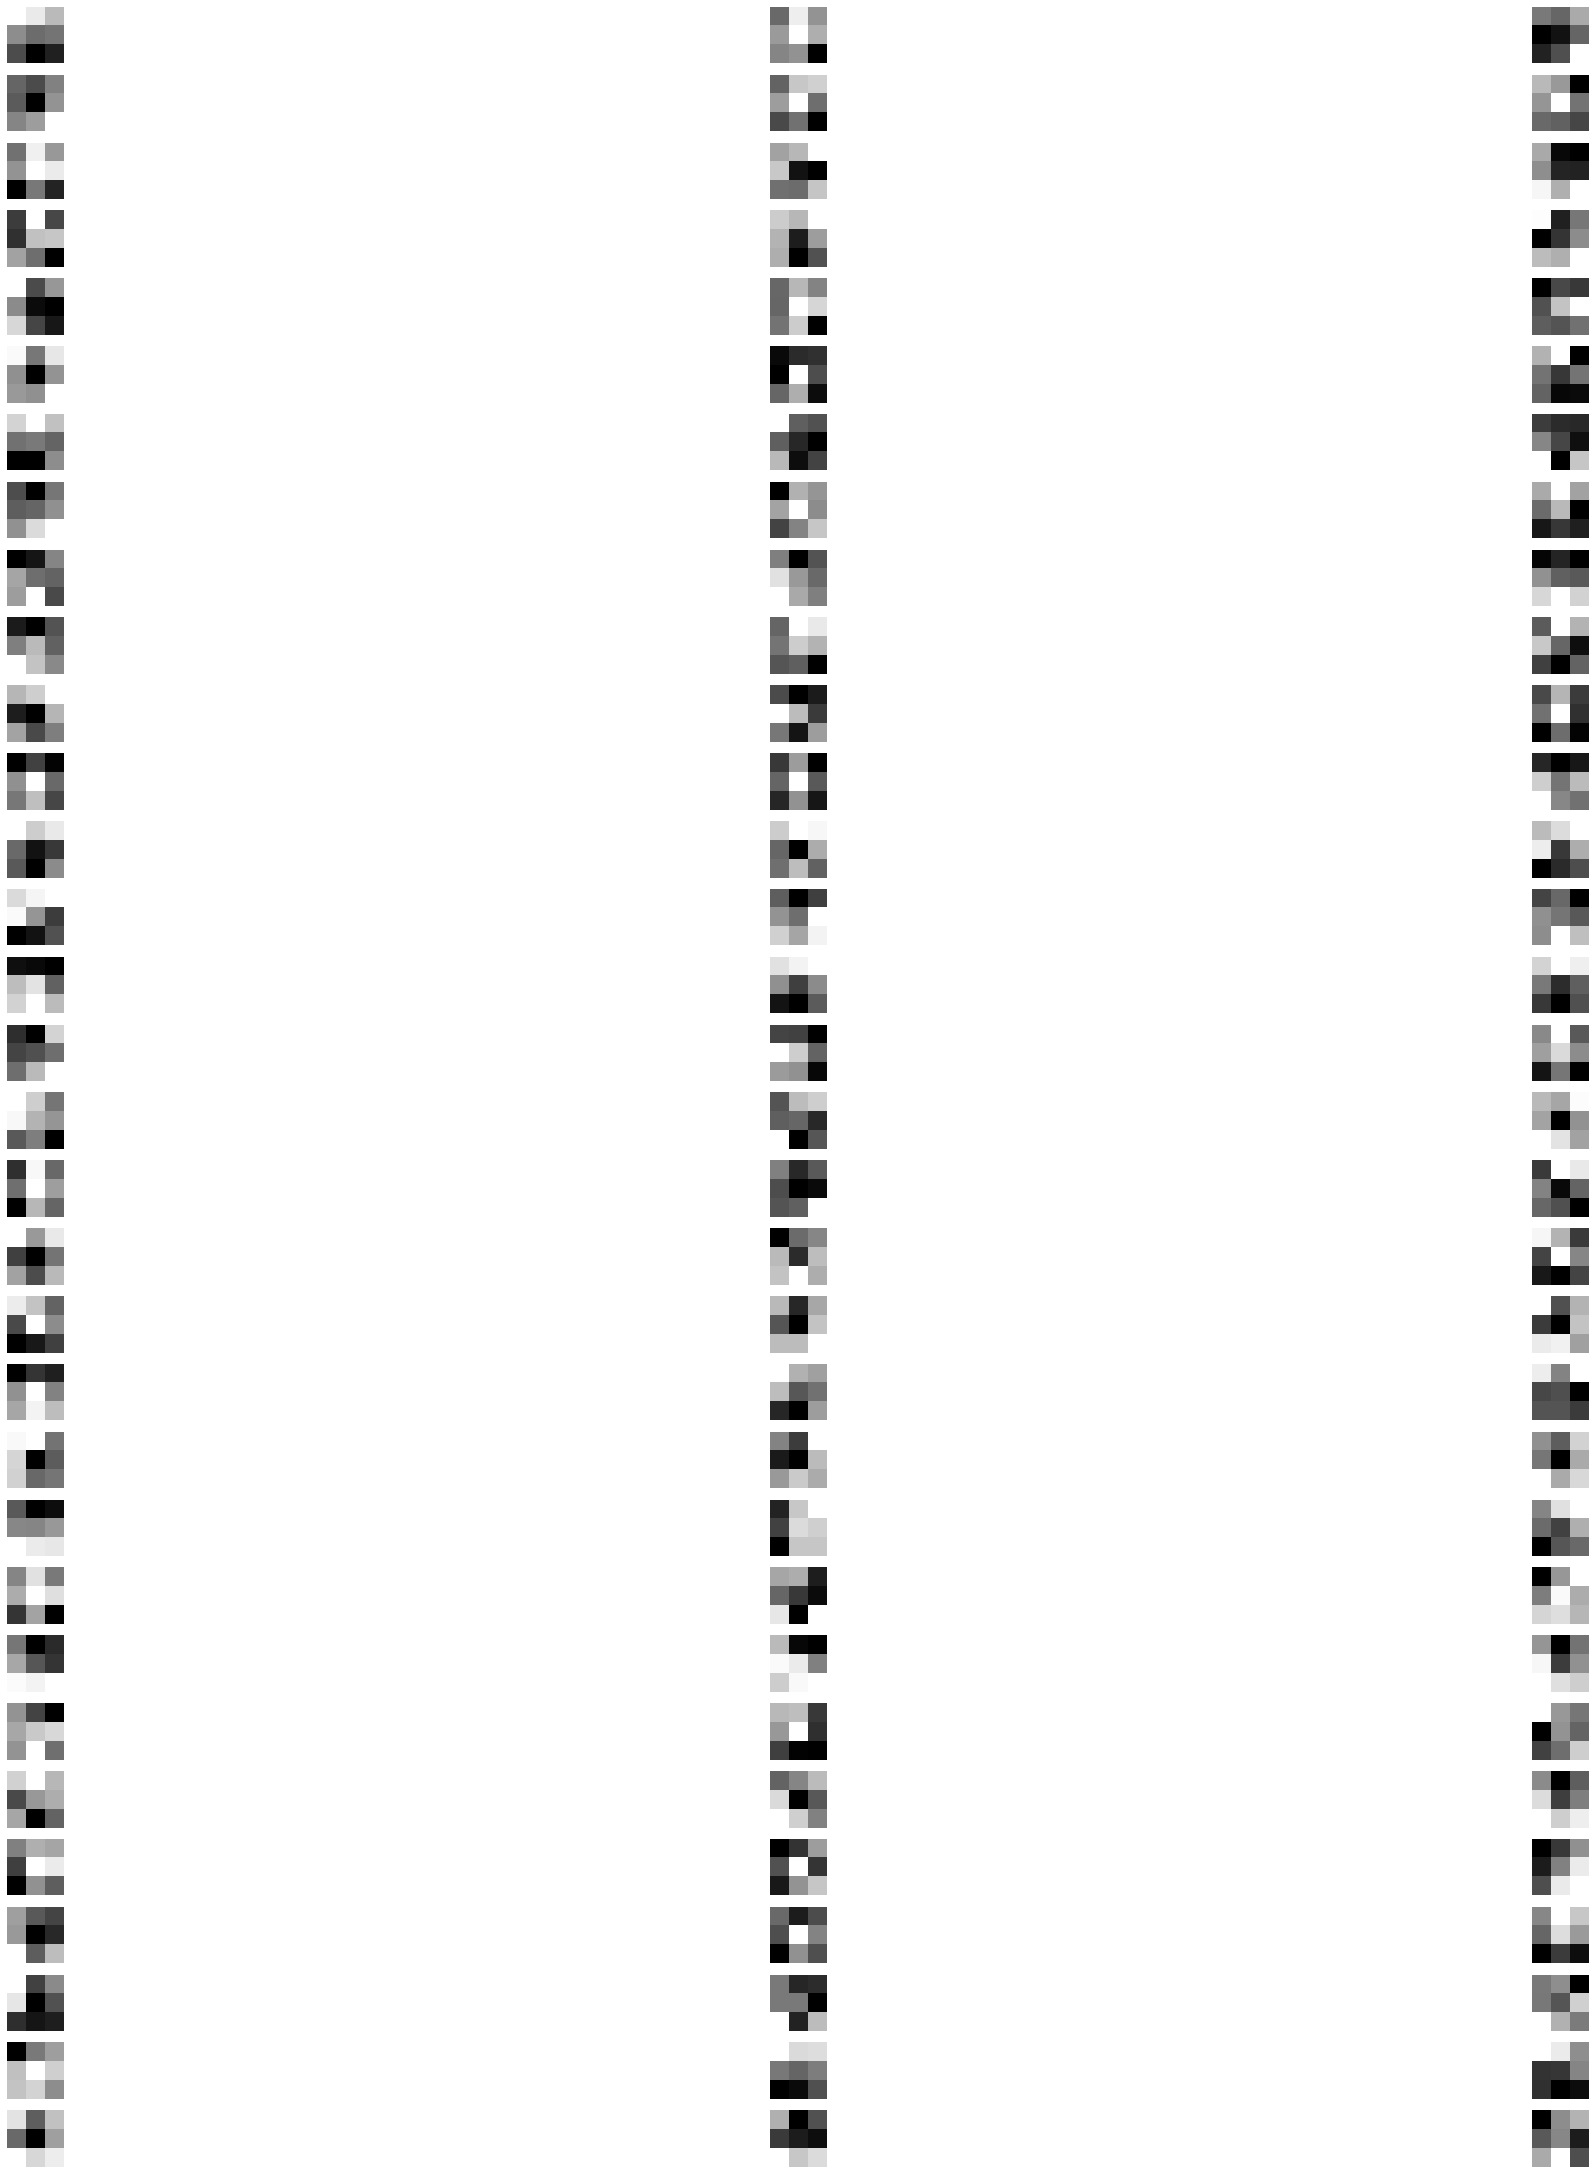

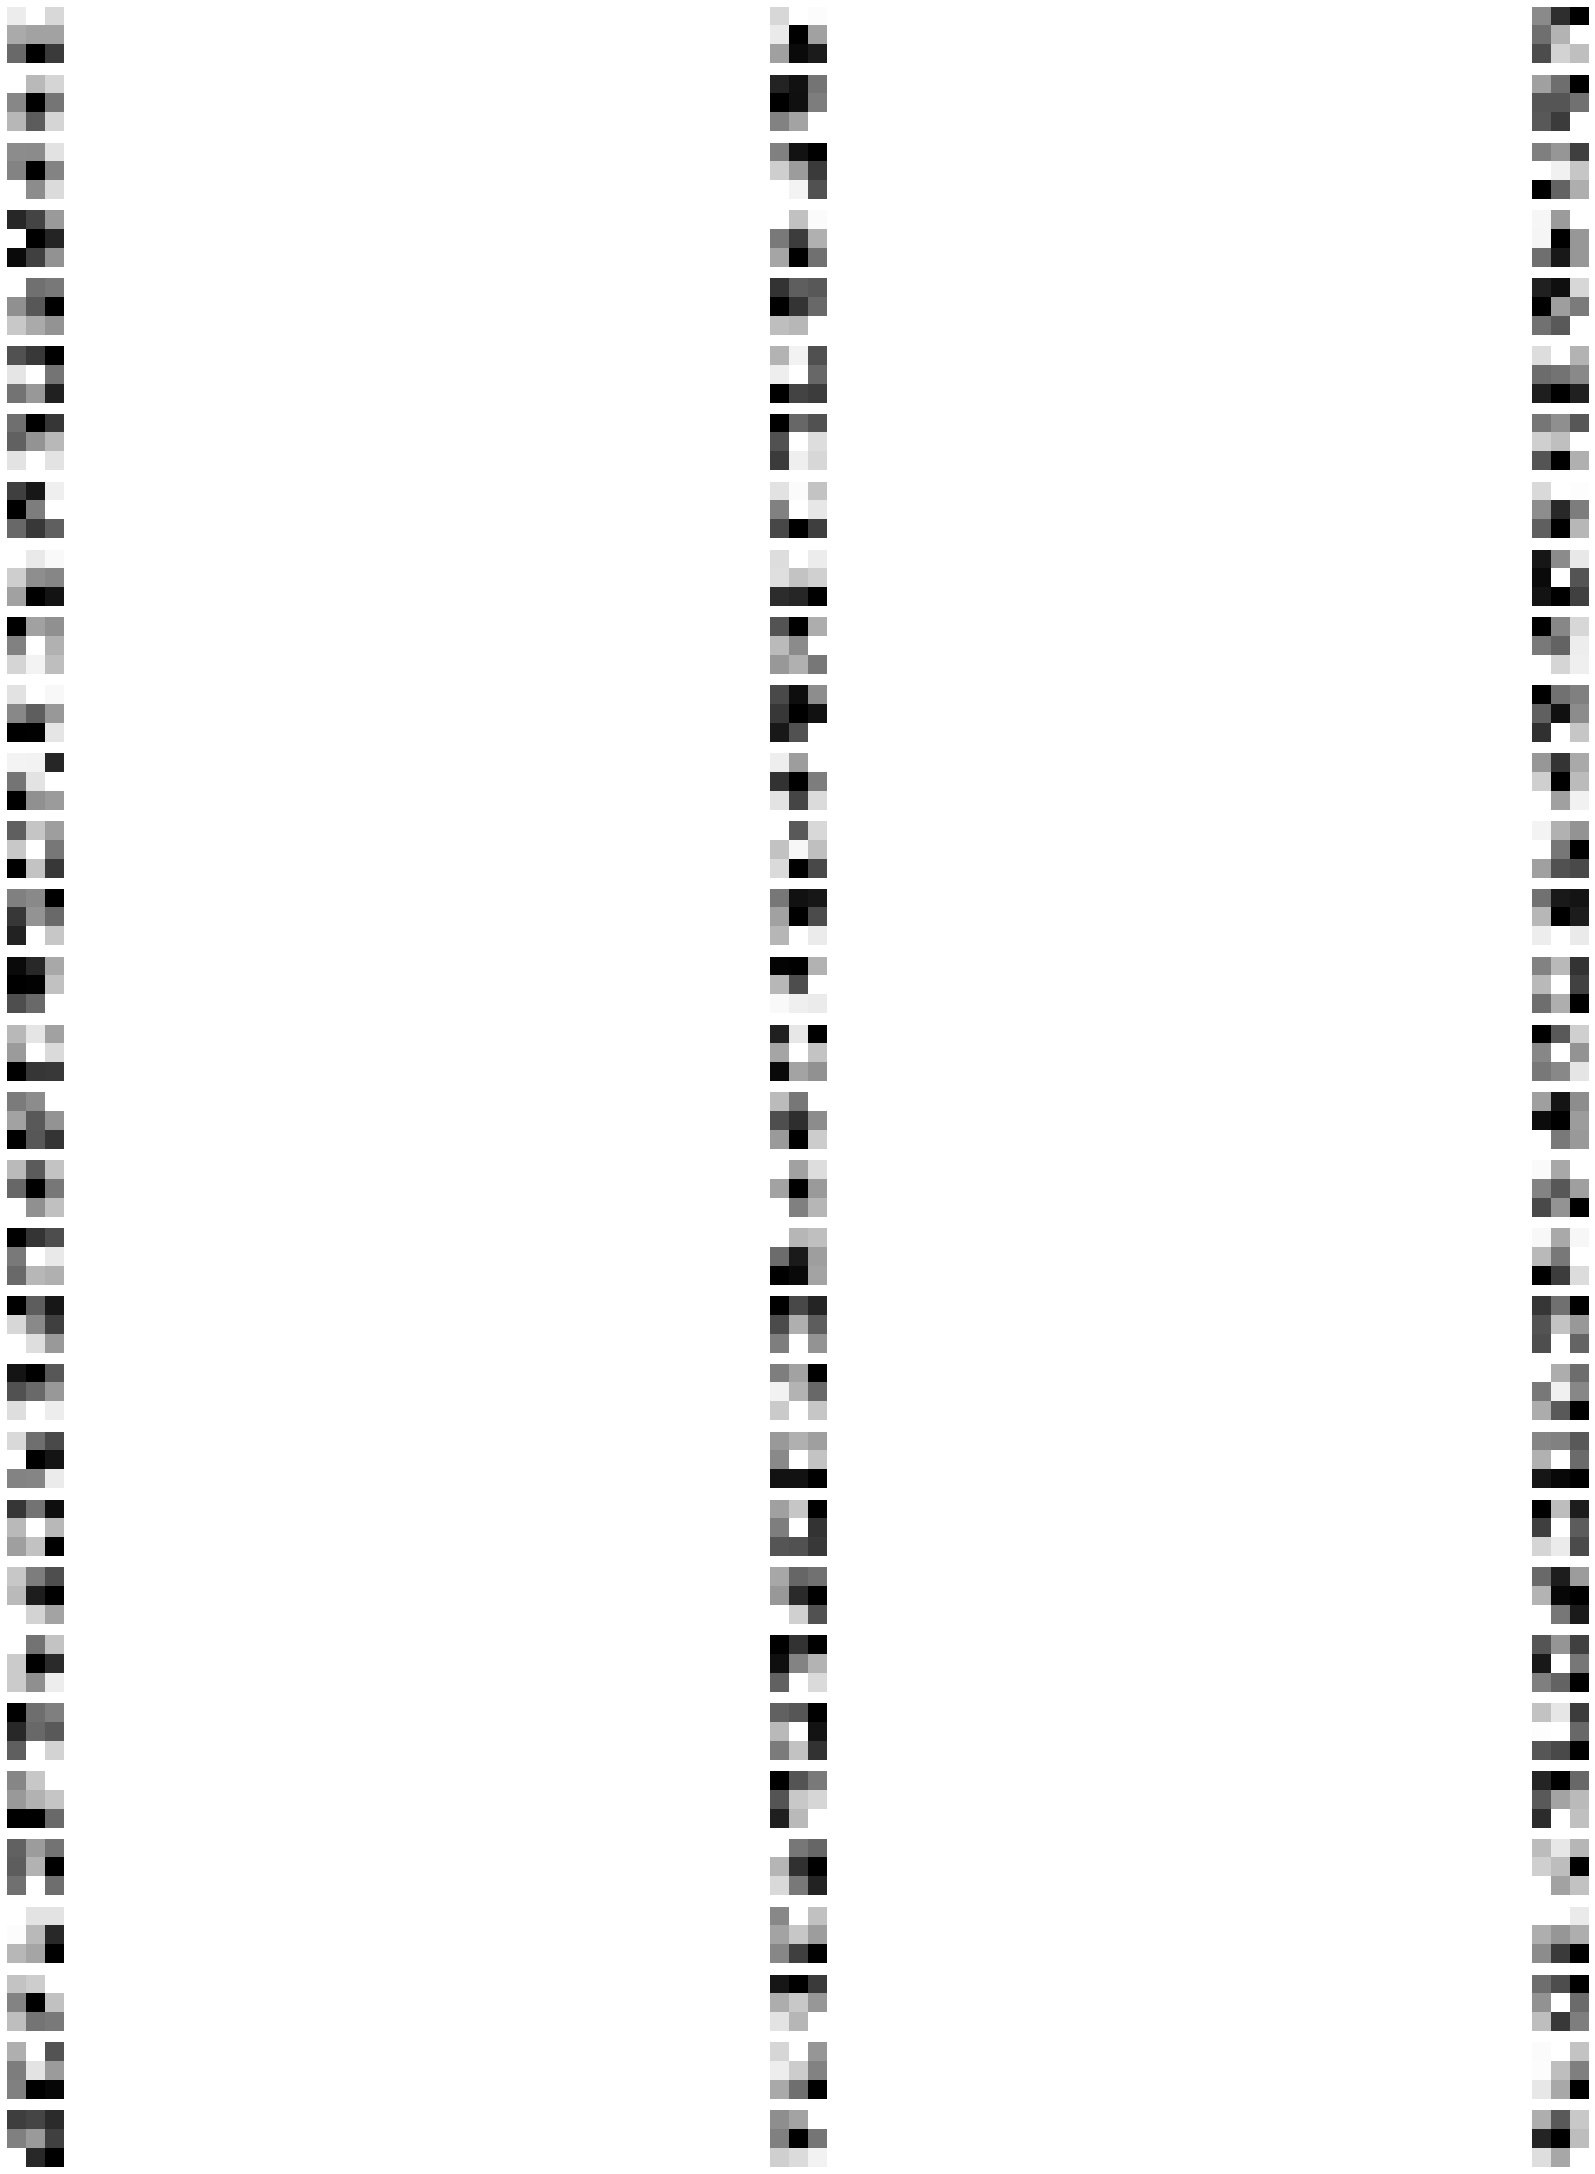

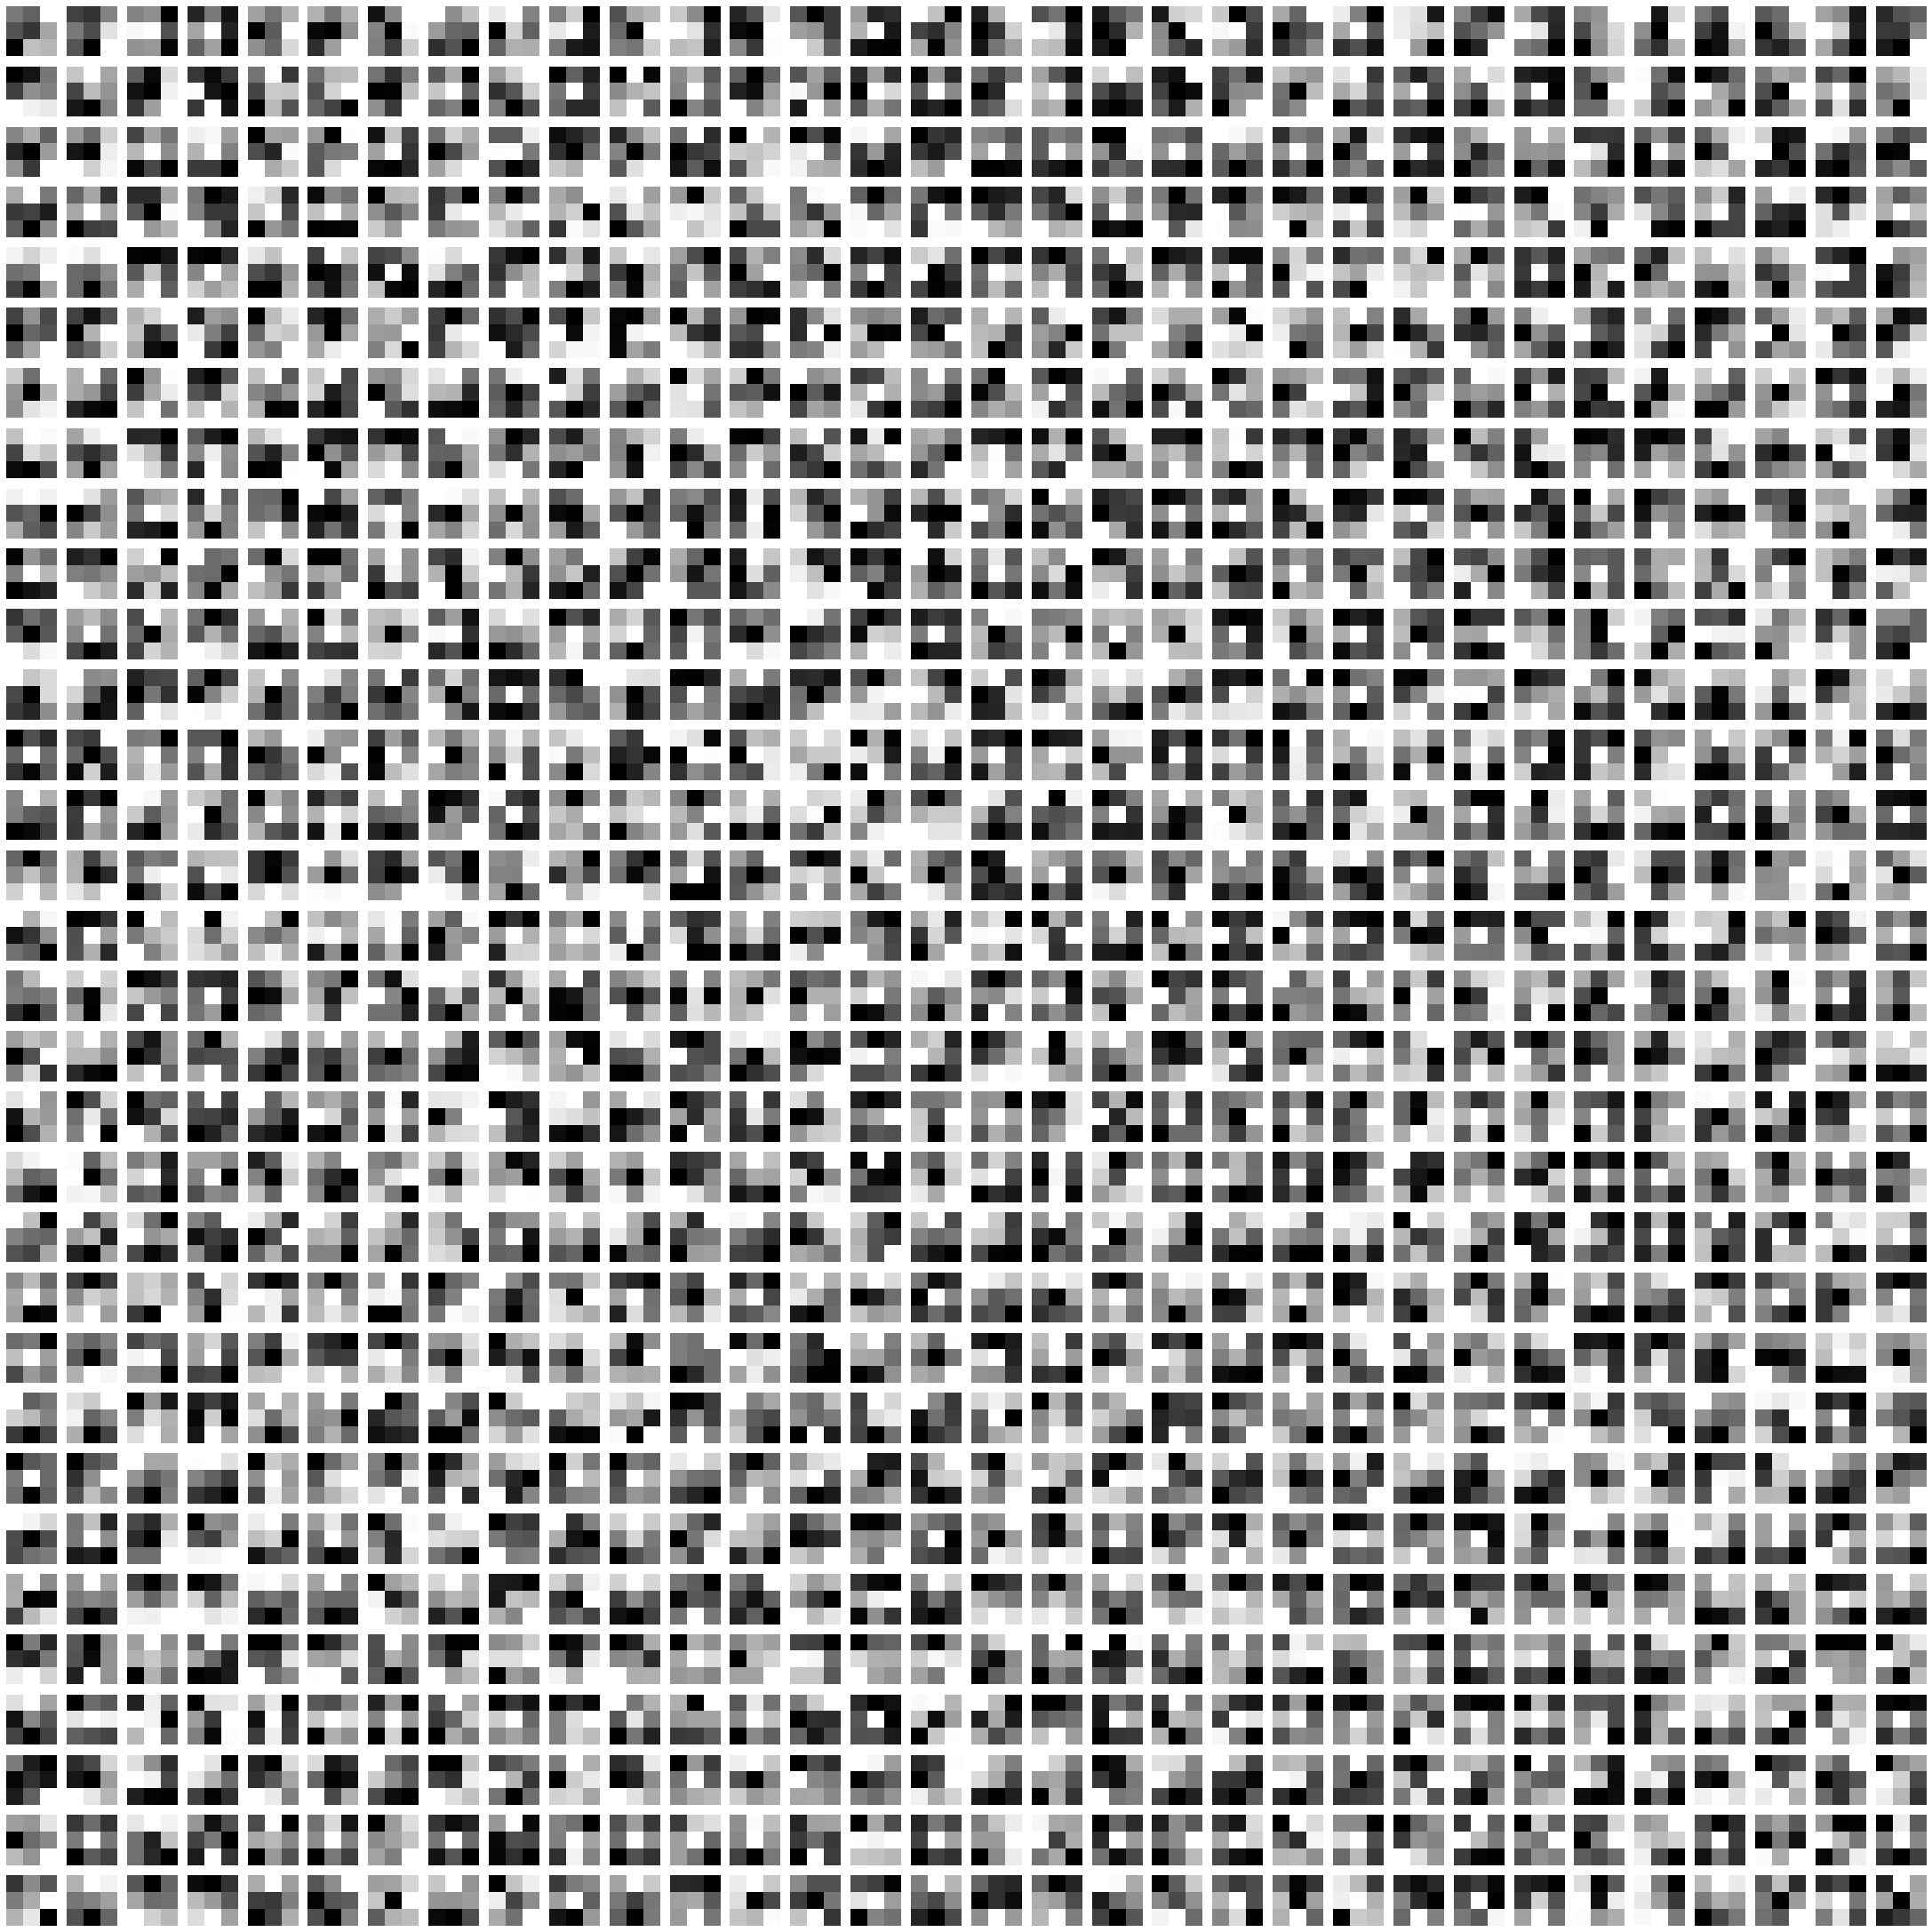

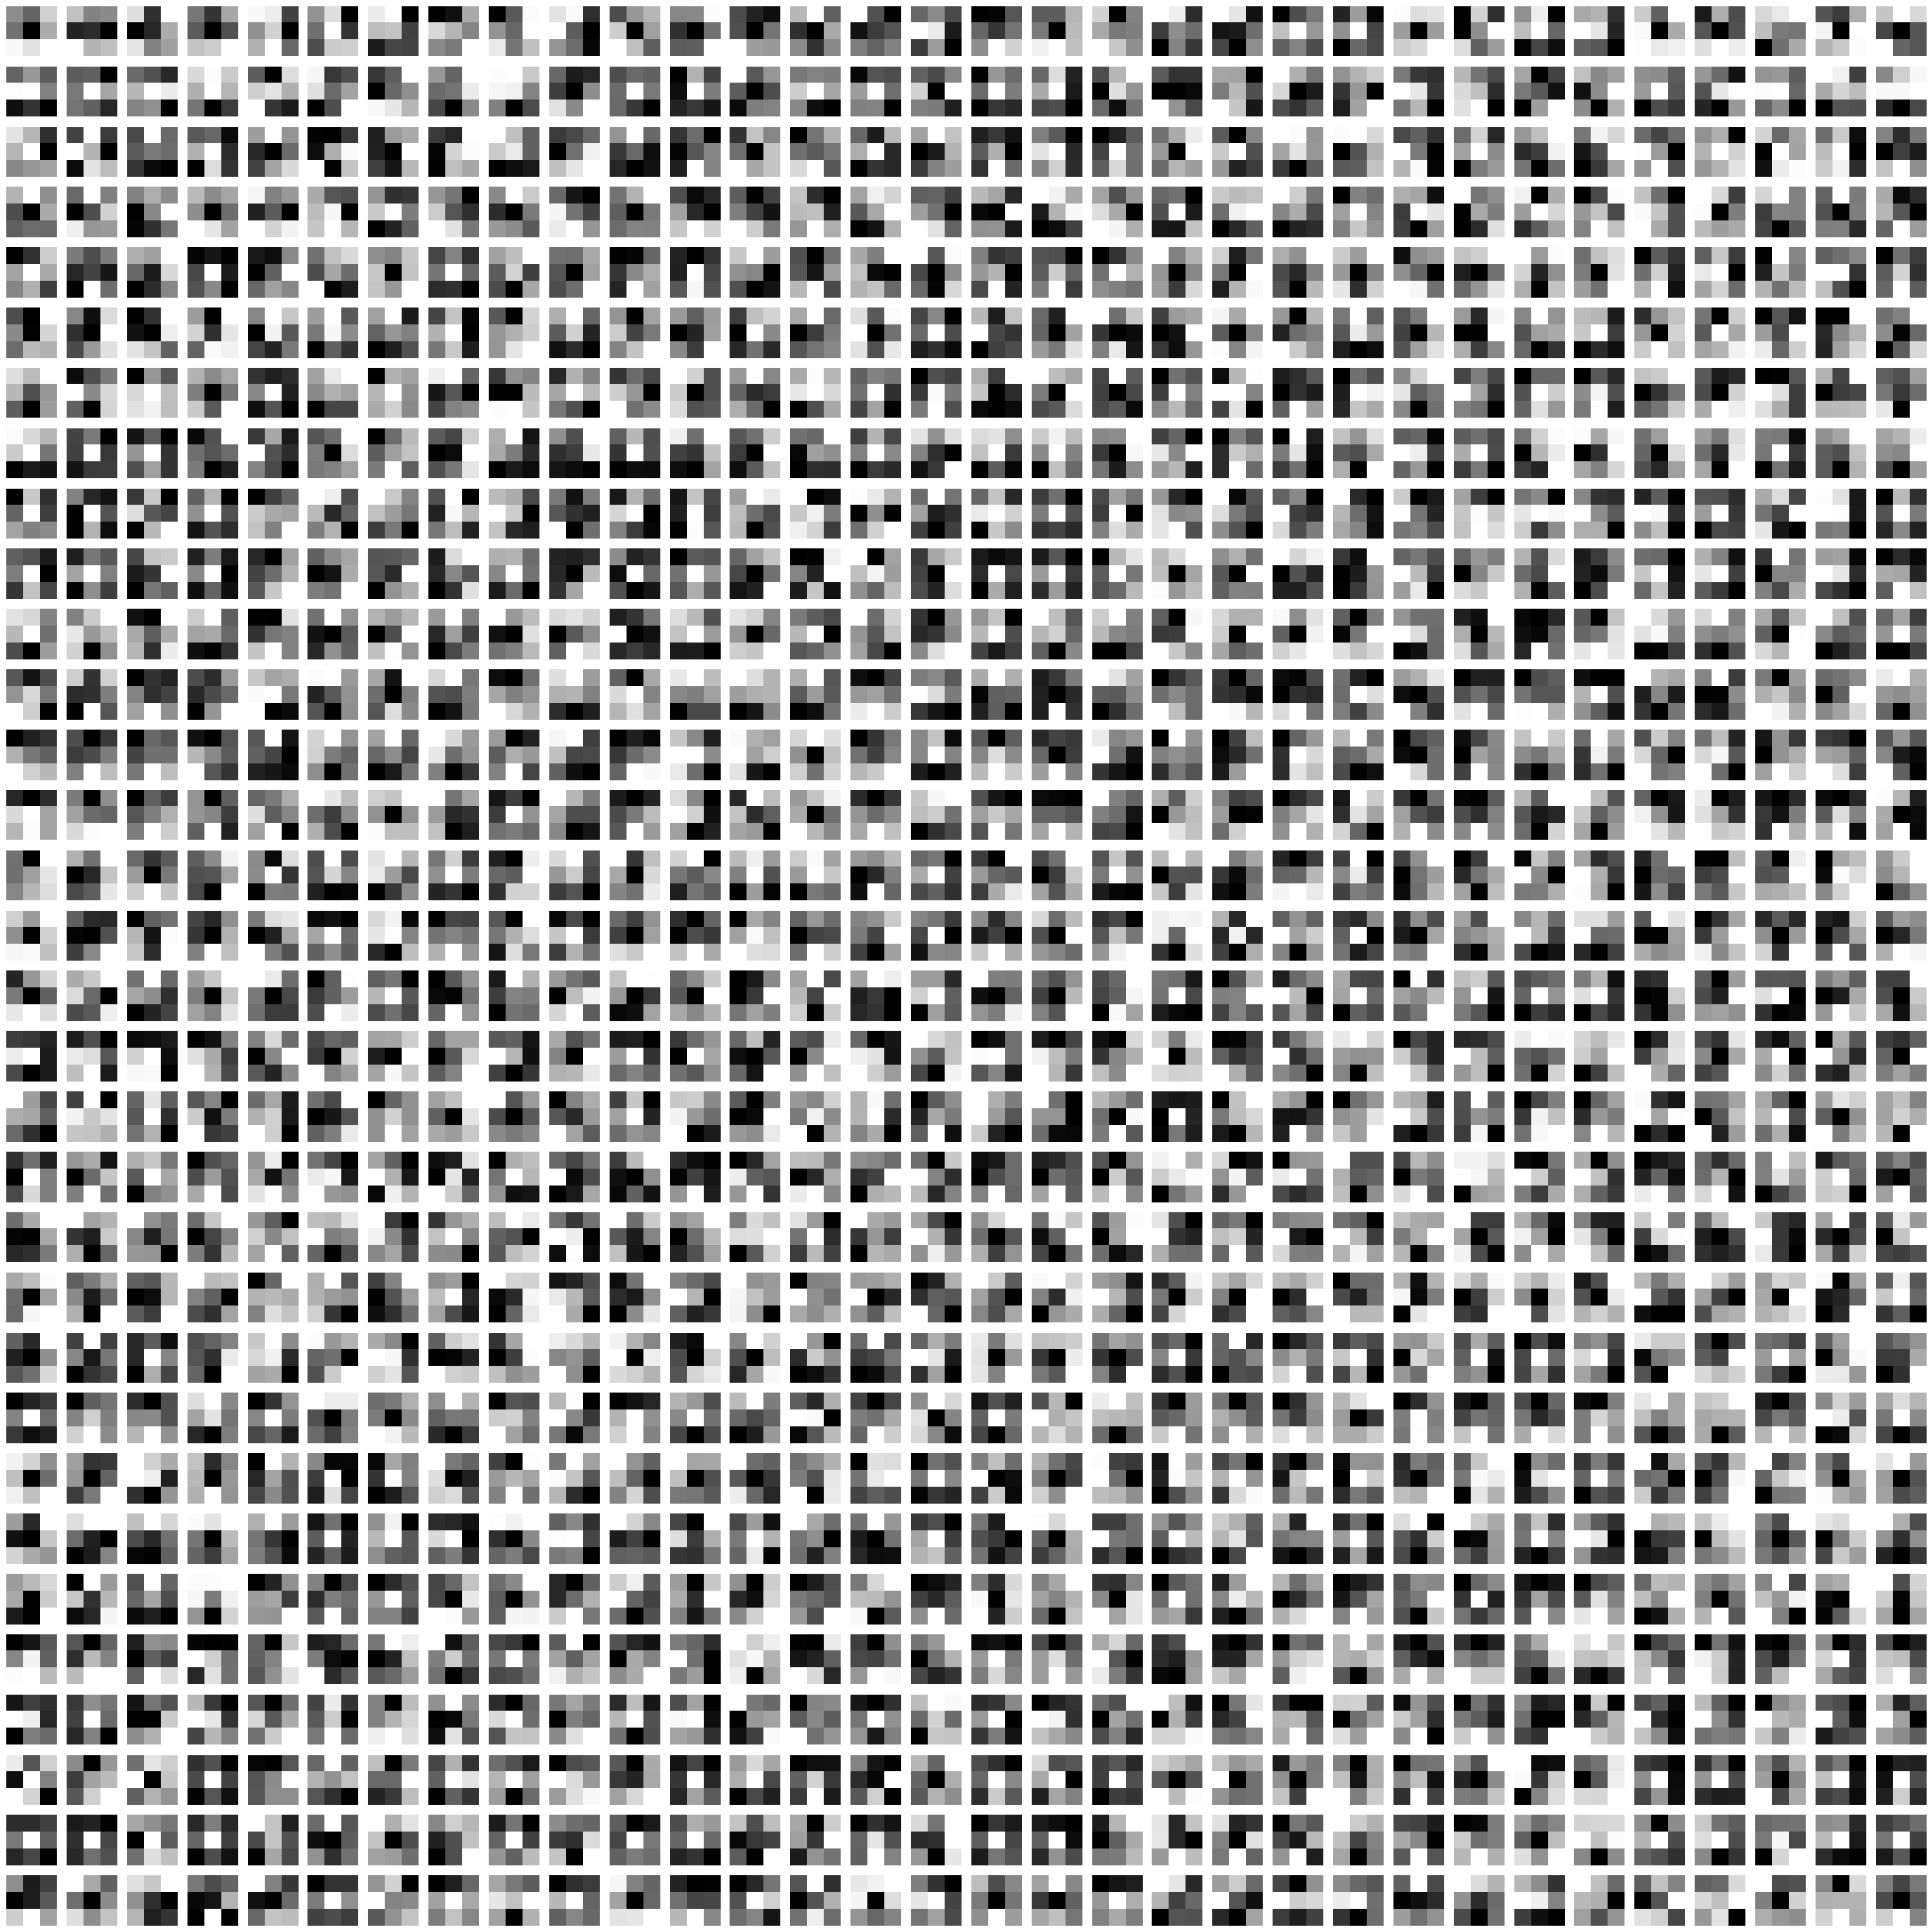

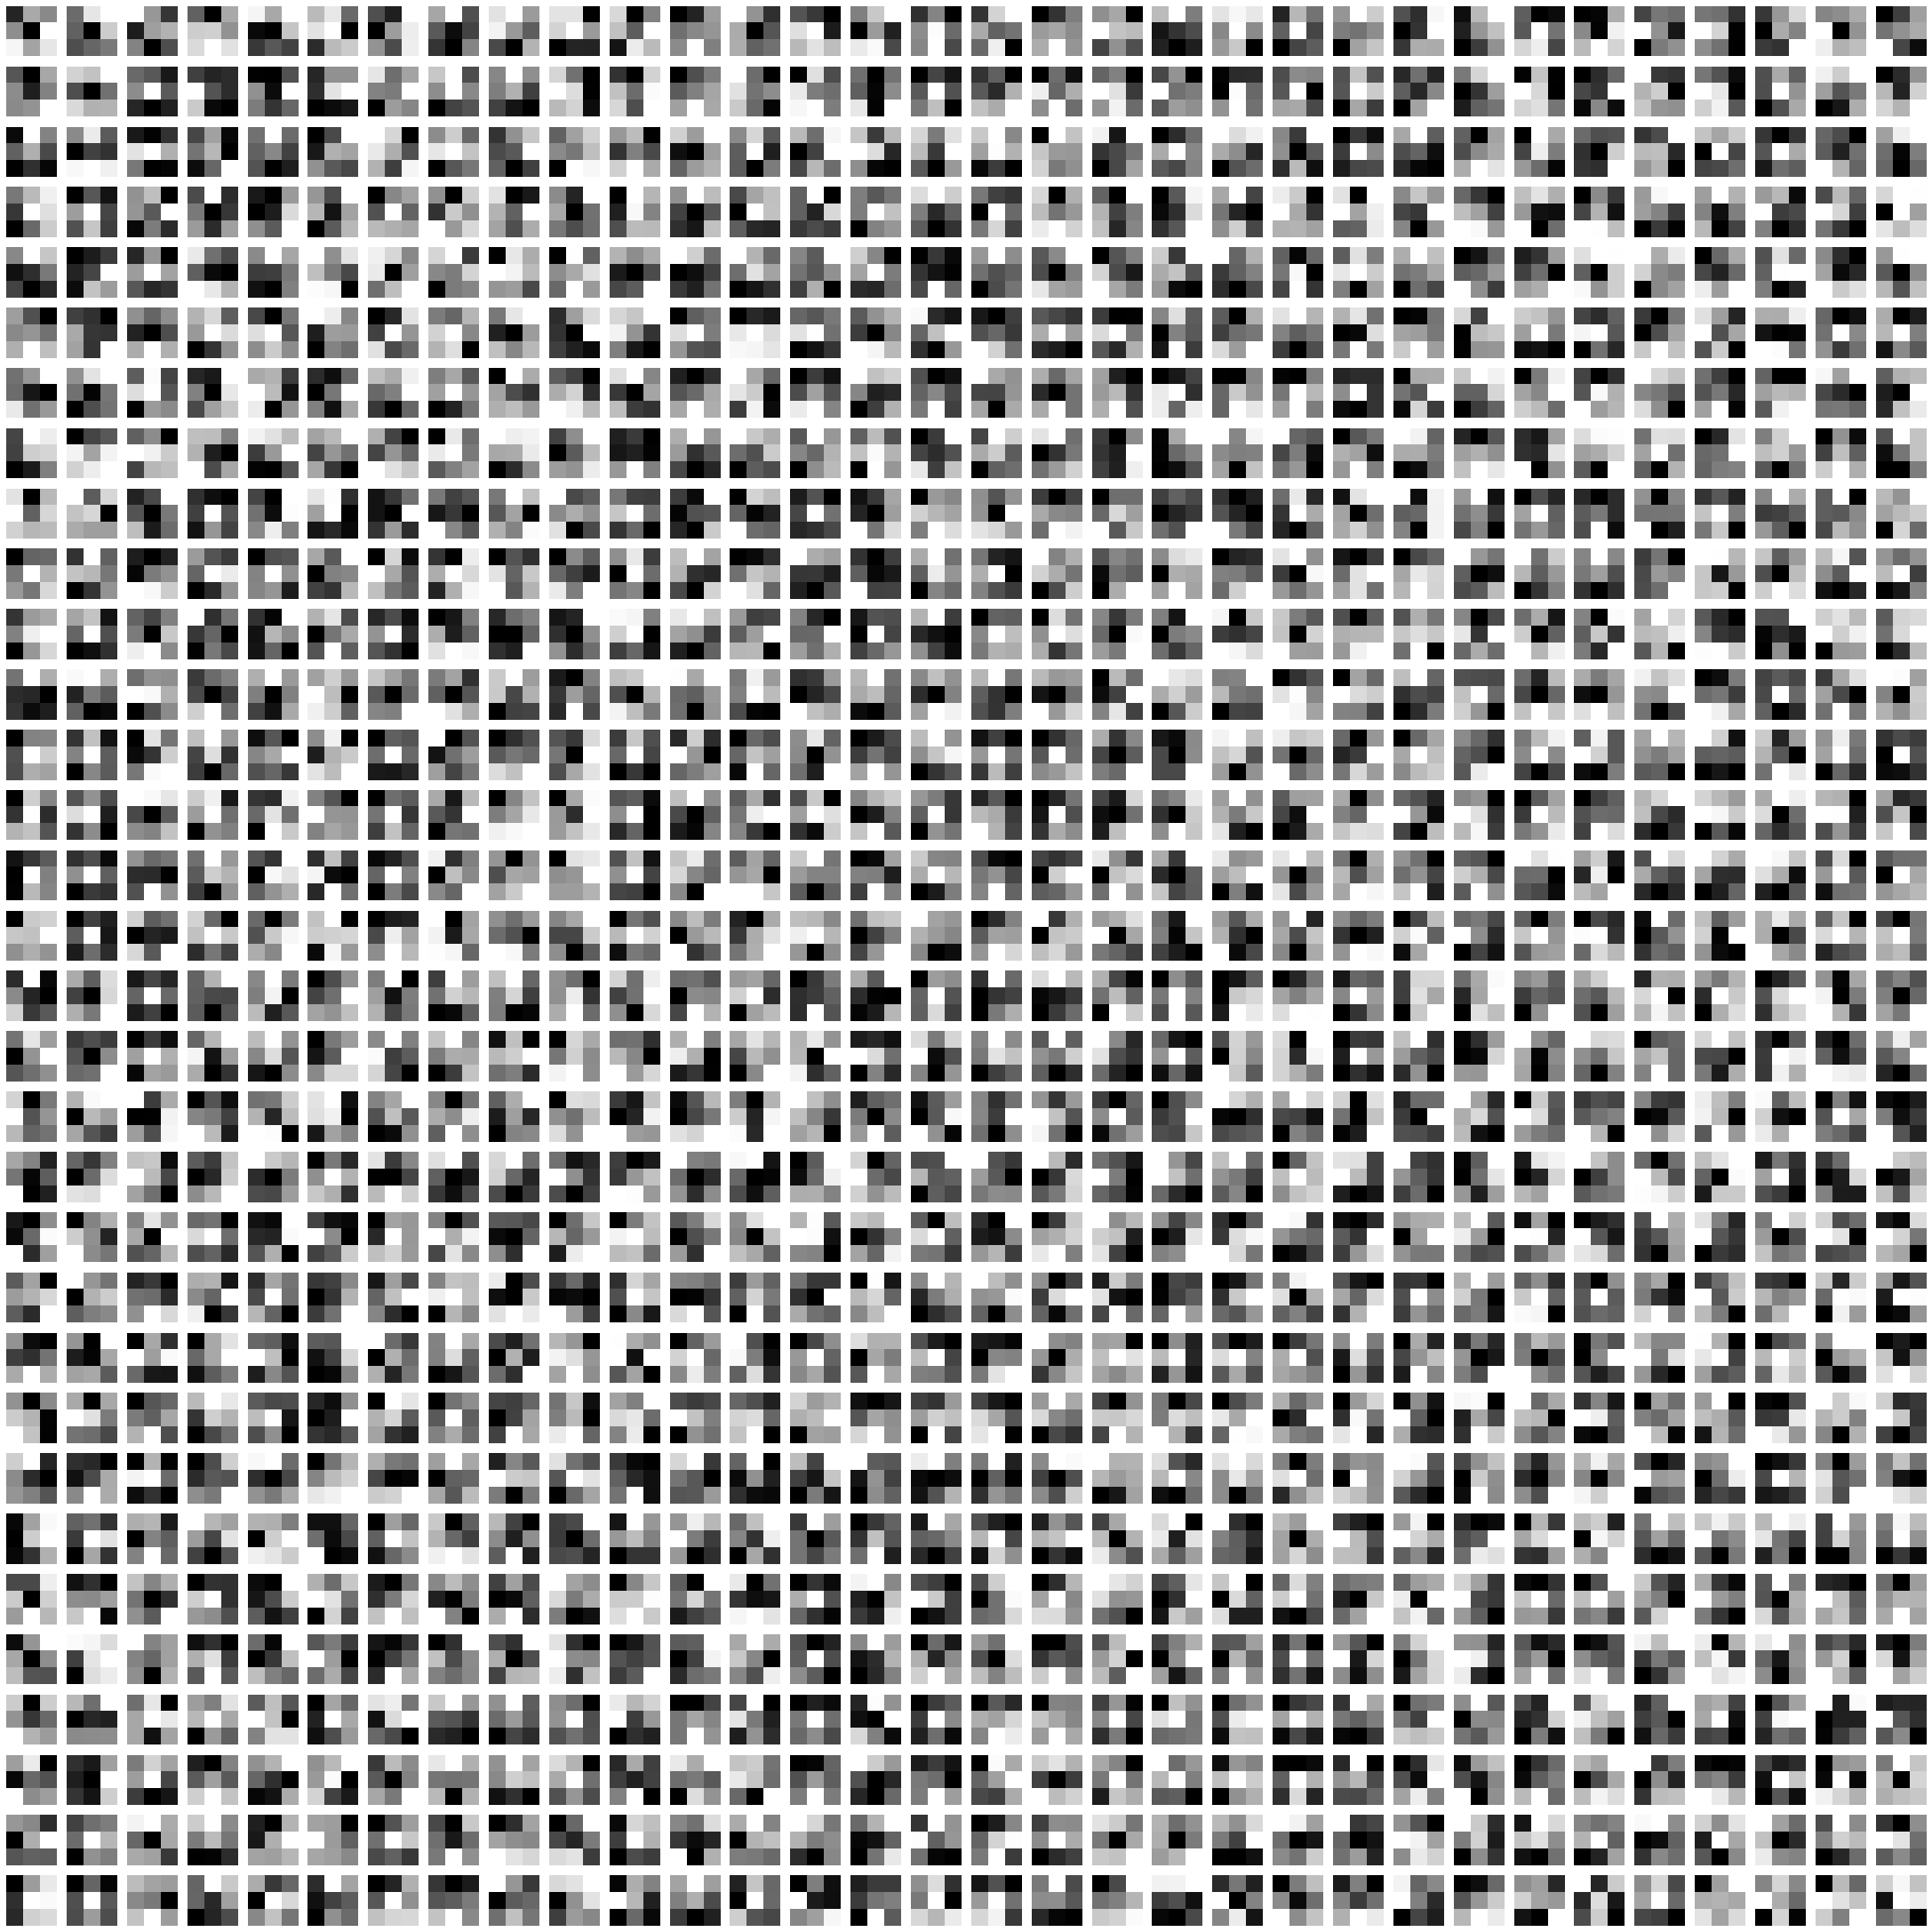

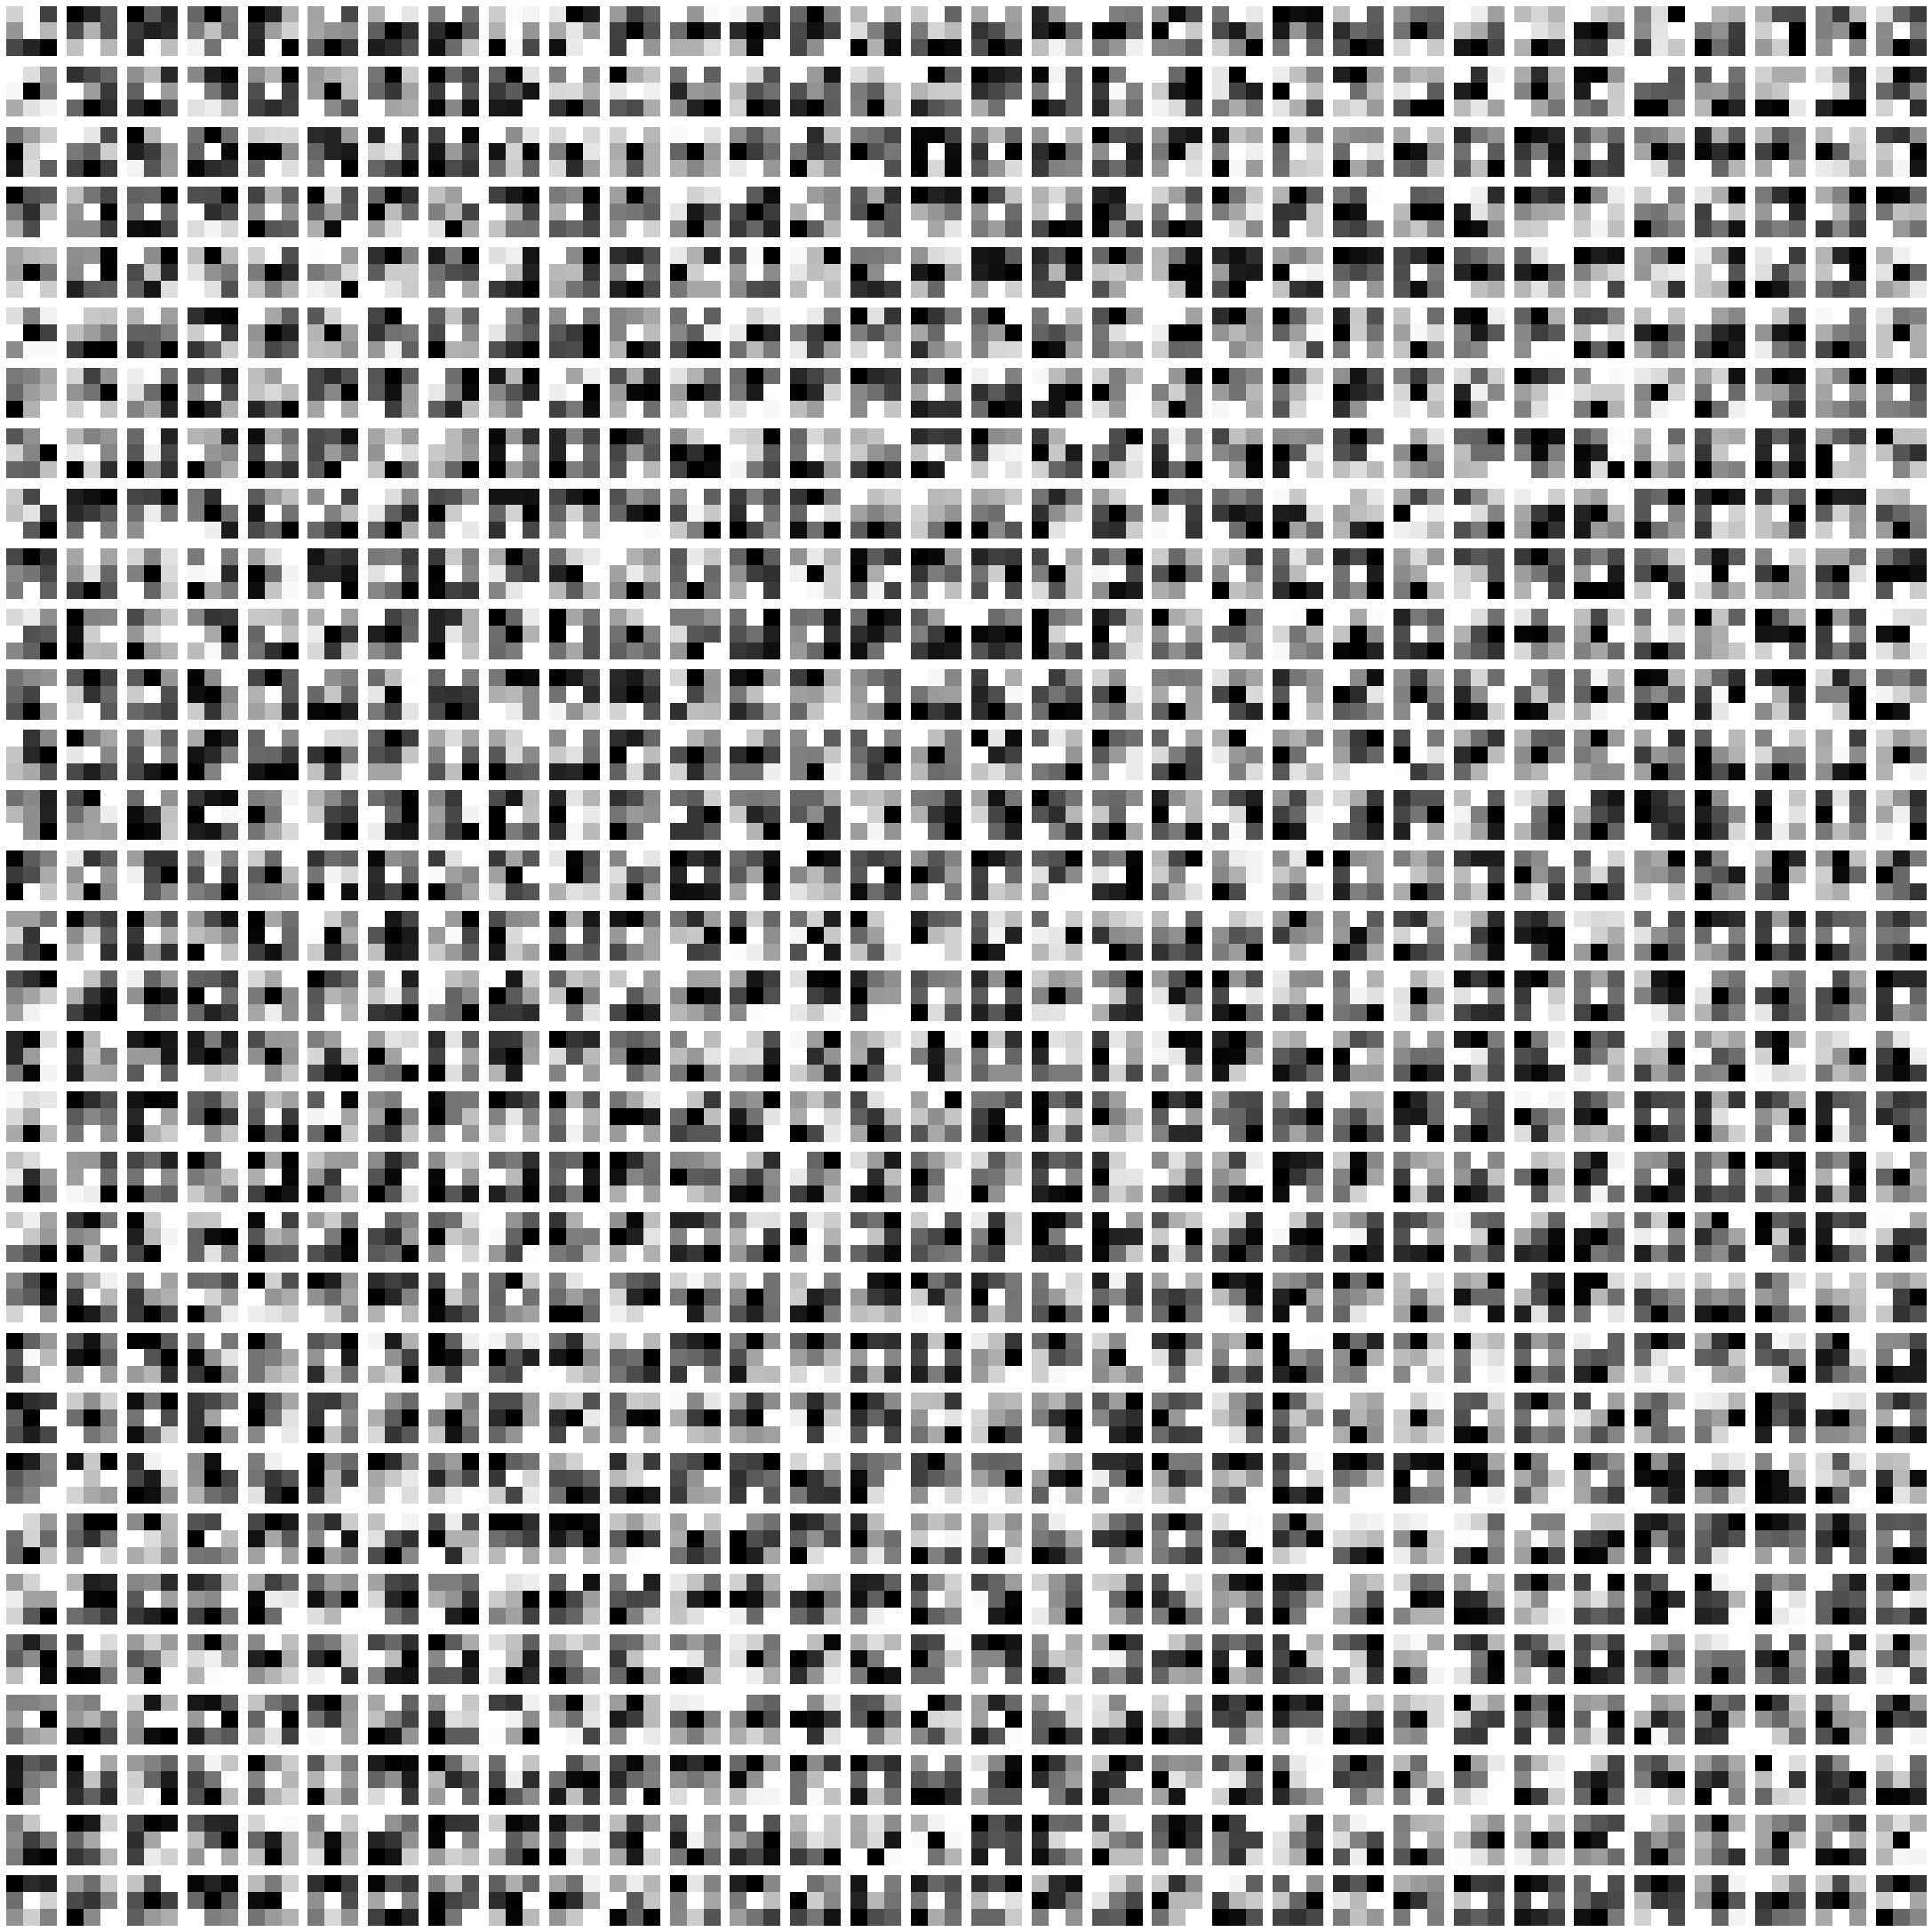

In [122]:
# Visualize kernels of conv0_x
for i in range(3):
    scene_flow_model_kernels = scene_flow_model_conv0_conv_weights[i]
    scene_flow_model_kernels = scene_flow_model_kernels - scene_flow_model_kernels.min()
    scene_flow_model_kernels = scene_flow_model_kernels / scene_flow_model_kernels.max()
    custom_kernal_viz(scene_flow_model_kernels, 'results/scene_flow_model/conv0_{}.weights.png'.format(i))
    
    kitti_2015_model_kernels = kitti_2015_model_conv0_conv_weights[i]
    kitti_2015_model_kernels = kitti_2015_model_kernels - kitti_2015_model_kernels.min()
    kitti_2015_model_kernels = kitti_2015_model_kernels / kitti_2015_model_kernels.max()
    custom_kernal_viz(kitti_2015_model_kernels, 'results/kitti_2015_model/conv0_{}.weights.png'.format(i))